# Be My Guest: A Data Science and Machine Learning Project
## Introduction
The hotel chain IMSInn, like many other hotels, has been keeping score of all the customer satisfaction surveys their guest kindly fill out and leave in their room after their stay. However, until know they were only used to obtain an overall satisfaction score.

Recent developments of the global pandemic have caused business to slow down and the marketing department is working like crazy to figure a strategy to keep the impacts at a minimum. The idea is to target customers with a high probability of returning and give them discounts if they make a booking for next year, helping to contain marketing costs while guarantying some cash inflow.

Your goal is to build a predictive model that answers the question “Which guests are more likely to return?” using the small quantity of data accessible from the guest data base that contains general information about the guests and their satisfaction survey responses, explained bellow.

## Datasets
The training set should be used to build your machine learning models. In this set, you also have the ground truth associated with each guest, i.e., if he returned or not.
The test set should be used to see how well your model performs on unseen data. In this set you don’t have access to the ground truth, and the goal of your team is to predict that value (“0” or “1”) by using the model you created using the training set.
The score of your predictions is calculated using f1 score.

## Deliverables
You should submit a csv file with the number of instances in the test set, containing the columns [Guest_ID, Repeater], and only those columns. The Repeater column should contain the prediction (“0” or “1”).

---

## Boilerplate
All necessary packages in the working environment.

In [279]:
# Import all the needed packages
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# importando os modelos que serão usados
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

---

## Importando o dataset

In [280]:
# Import the dataset, drop duplicates
data = pd.read_csv(r'./datasets/train.csv')
data.set_index('Guest_ID', inplace = True)
data.head()

,Name,Frequent_Traveler,Date_Birth,Type,Flight_Class,Points,Room,Check-in/Check-out,F&B,Location,...,Spa,Staff,Pool,Baggage_Handling,Reception,Cleanliness,Online_Booking,Deposit_Kept,Time_Room_Service,Repeater
Guest_ID,,,,,,,,,,,,,,,,,,,,,
19346,Mr. James Bond,1,"July 1, 1991",Business travel,Eco,2695,3,5,5,5,...,4,2,3,3,3,3,3,187,20.2,0
21830,Mr. Christian Newman,1,"January 25, 1964",Personal Travel,Eco,2057,2,1,2,4,...,3,2,5,3,4,3,3,0,1.2,0
17626,Miss Megan Welch,1,"May 10, 2005",Personal Travel,Eco,1478,2,2,2,2,...,4,4,4,4,3,4,5,0,0.0,1
17988,Miss Carol Gibson,1,"March 25, 1973",Business travel,Business,2304,3,1,1,1,...,1,2,4,4,3,2,3,147,15.0,0
16703,Mrs. Jessica Tucker,1,"May 29, 1969",Business travel,Eco,73,3,3,3,3,...,3,3,3,3,4,3,3,6,1.0,1


__Data fields__
- `Guest_ID` - Unique identifier of the guest
- `Name` - The name of the guest
- `Frequent_Traveler` - Binary variable indicating if the guest is a frequent flier or not
- `Date_Birth` - Guest date of birth
- `Type` - Reason for travelling
- `Flight_Class` - Class of flight took to get to the hotel
- `Points` - Points from travel club membership
- `Room` - Evaluation of the room (0 to 5)
- `Check-in/Check-out` - Evaluation of the check-in/check-out process (0 to 5)
- `F&B` - Evaluation of the food and beverages (0 to 5)
- `Location` - Evaluation of the hotel location (0 to 5)
- `Wifi` - Evaluation of the hotel wifi (0 to 5)
- `Entertainment` - Evaluation of the entertainment offer (0 to 5)
- `Gym` - Evaluation of the gym (0 to 5)
- `Spa` - Evaluation of the spa (0 to 5)
- `Staff` - Evaluation of the staff (0 to 5)
- `Pool` - Evaluation of the pool (0 to 5)
- `Baggage_Handling` - Evaluation of the baggage handling process (0 to 5)
- `Reception` - Evaluation of the reception (0 to 5)
- `Cleanliness` - Evaluation of the cleanliness (0 to 5)
- `Online_Booking` - Evaluation of the online booking process (0 to 5)
- `Deposit_Kept` - Amount withdrawn from the credit card of the guest to cover damages
- `Time_Room_Service` - Average time (minutes) the guest waited to receive room service
- `Repeater` - Binary variable signaling if the customer returned or not (up until a year after the first visit)

Data Types for Independent Variables:
- __`Categorical`__ - Type, Flight_Class
- __`Continuous`__ - Date_Birth, Points, Deposit_Kept, Time_Room_Service
- __`Binary`__ - Frequent_Traveler    
- __`Ordinal`__ - Room, Check-in/Check-out, F&B, Location, Wifi, Entertainment, Gym, Spa, Staff, Pool, Baggage_Handling, Reception, Cleanliness, Online_Booking

Missing values:
- Date_Birth (continuous)

## Explorando o dataset

In [281]:
# small exploration on the data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9100 entries, 19346 to 22235
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                9100 non-null   object 
 1   Frequent_Traveler   9100 non-null   int64  
 2   Date_Birth          8995 non-null   object 
 3   Type                9100 non-null   object 
 4   Flight_Class        9100 non-null   object 
 5   Points              9100 non-null   int64  
 6   Room                9100 non-null   int64  
 7   Check-in/Check-out  9100 non-null   int64  
 8   F&B                 9100 non-null   int64  
 9   Location            9100 non-null   int64  
 10  Wifi                9100 non-null   int64  
 11  Entertainment       9100 non-null   int64  
 12  Gym                 9100 non-null   int64  
 13  Spa                 9100 non-null   int64  
 14  Staff               9100 non-null   int64  
 15  Pool                9100 non-null   int64  
 16  B

## Exploração Estatística

In [282]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Frequent_Traveler,9100.0,0.814505,0.388720,0.0,1.0,1.0,1.0,1.0
Points,9100.0,1969.286813,1019.192578,50.0,1354.0,1916.0,2529.0,6097.0
Room,9100.0,2.847363,1.388212,0.0,2.0,3.0,4.0,5.0
Check-in/Check-out,9100.0,2.976484,1.539135,0.0,2.0,3.0,4.0,5.0
F&B,9100.0,2.858352,1.442011,0.0,2.0,3.0,4.0,5.0
Location,9100.0,2.989560,1.301297,0.0,2.0,3.0,4.0,5.0
Wifi,9100.0,3.239780,1.311509,0.0,2.0,3.0,4.0,5.0
Entertainment,9100.0,3.393846,1.336398,0.0,2.0,4.0,4.0,5.0
Gym,9100.0,3.514505,1.297452,1.0,3.0,4.0,5.0,5.0
Spa,9100.0,3.477692,1.300556,0.0,2.0,4.0,5.0,5.0


<AxesSubplot:xlabel='Staff', ylabel='Count'>

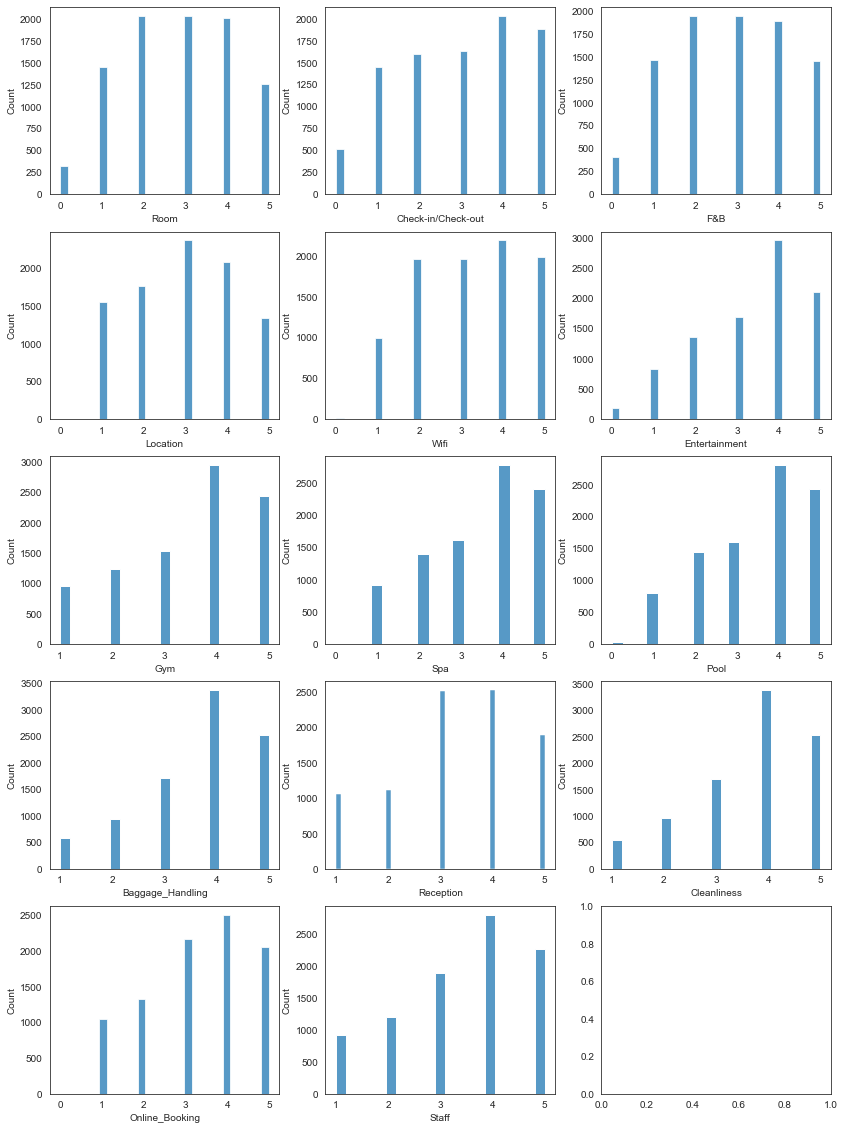

In [283]:
# histplot das notas
sns.set_style("white")

fig, axes = plt.subplots(5,3, figsize = (14,20))
sns.histplot(ax = axes[0,0], data = data, x = 'Room')
sns.histplot(ax = axes[0,1], data = data, x = 'Check-in/Check-out')
sns.histplot(ax = axes[0,2], data = data, x = 'F&B')
sns.histplot(ax = axes[1,0], data = data, x = 'Location')
sns.histplot(ax = axes[1,1], data = data, x = 'Wifi')
sns.histplot(ax = axes[1,2], data = data, x = 'Entertainment')
sns.histplot(ax = axes[2,0], data = data, x = 'Gym')
sns.histplot(ax = axes[2,1], data = data, x = 'Spa')
sns.histplot(ax = axes[2,2], data = data, x = 'Pool')
sns.histplot(ax = axes[3,0], data = data, x = 'Baggage_Handling')
sns.histplot(ax = axes[3,1], data = data, x = 'Reception')
sns.histplot(ax = axes[3,2], data = data, x = 'Cleanliness')
sns.histplot(ax = axes[4,0], data = data, x = 'Online_Booking')
sns.histplot(ax = axes[4,1], data = data, x = 'Staff')

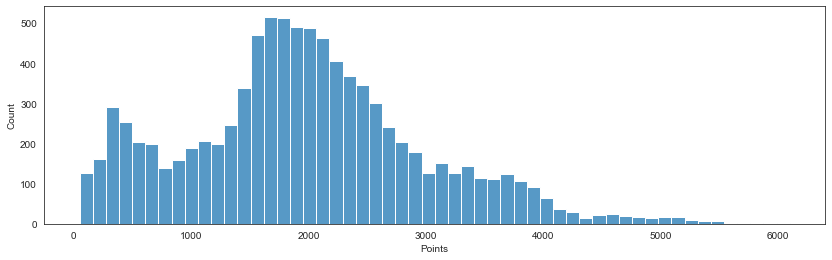

In [285]:
# histogramas das variáveis contínuas
fig, axes = plt.subplots(figsize = (14,4))
sns.histplot(data = data, x = 'Points')
plt.show()

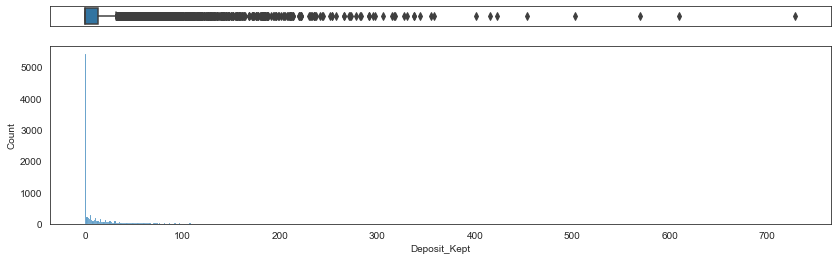

In [286]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.1, .9)}, figsize = (14,4))
sns.boxplot(data['Deposit_Kept'], ax = ax_box, )
sns.histplot(ax = ax_hist, data = data, x = 'Deposit_Kept')
ax_box.set(xlabel='')
plt.show()

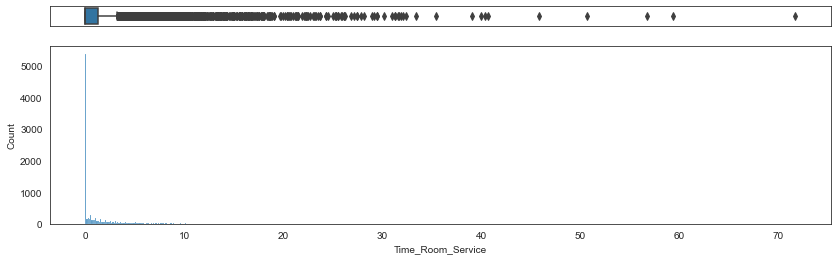

In [287]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.1, .9)}, figsize = (14,4))
sns.boxplot(data['Time_Room_Service'], ax = ax_box, )
sns.histplot(ax = ax_hist, data = data, x = 'Time_Room_Service')
ax_box.set(xlabel='')
plt.show()

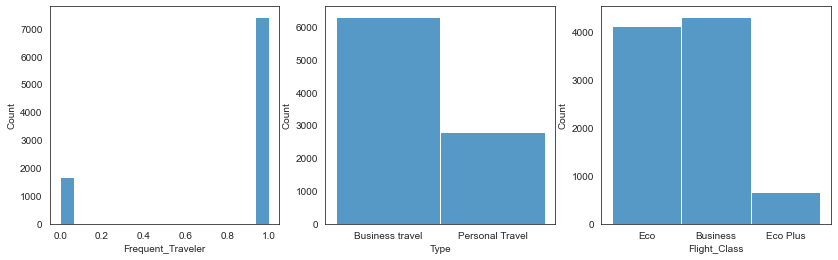

In [288]:
# barplot das varivaveis categóricas
fig, axes = plt.subplots(1,3, figsize = (14,4))
sns.histplot(ax = axes[0], data = data, x = 'Frequent_Traveler')
sns.histplot(ax = axes[1], data = data, x = 'Type')
sns.histplot(ax = axes[2], data = data, x = 'Flight_Class')
plt.show()

## Transformando alguns dados:
- Deposit_Kept e Time_Room_Service: log
- Flight_Class: Agrupar Eco e Eco Plus
- Age: fillna com a mediana

In [289]:
data['Name'].str.slice(0,4).value_counts()

Mr.     4478
Mrs.    3218
Miss    1404
Name: Name, dtype: int64

In [290]:
# criando dataest com transformadas
data_trans = data.copy()

# criando a variável de gênero
data_trans['Gender'] = data_trans['Name'].str.slice(0,4)
data_trans['Gender'].replace('Mr. ', 'M', inplace = True)
data_trans['Gender'].replace('Mrs.', 'F', inplace = True)
data_trans['Gender'].replace('Miss', 'F', inplace = True)
data_trans.drop('Name', axis = 1, inplace = True)

# convertendo variáveis: Date_Birth, Age
data_trans['Date_Birth'] = pd.to_datetime(data_trans['Date_Birth'])
data_trans['Age'] = 2021 - data_trans['Date_Birth'].dt.year
data_trans.drop('Date_Birth', axis = 1, inplace = True)


# transformando log
data_trans['Deposit_Kept_Log'] = data_trans['Deposit_Kept'] + 1
data_trans['Deposit_Kept_Log'] = np.log(data_trans['Deposit_Kept_Log'])
data_trans['Time_Room_Service_Log'] = data_trans['Time_Room_Service'] + 1
data_trans['Time_Room_Service_Log'] = np.log(data_trans['Time_Room_Service_Log'])

# agrupando eco e ecoplus
# data_trans['Flight_Class_Group'] = data_trans['Flight_Class']
# data_trans['Flight_Class_Group'].loc[data_trans['Flight_Class_Group'] == 'Eco Plus'] = 'Eco'

# preenchendo na em Age
#data_trans.fillna({'Age': data_trans['Age'].median()}, inplace = True)


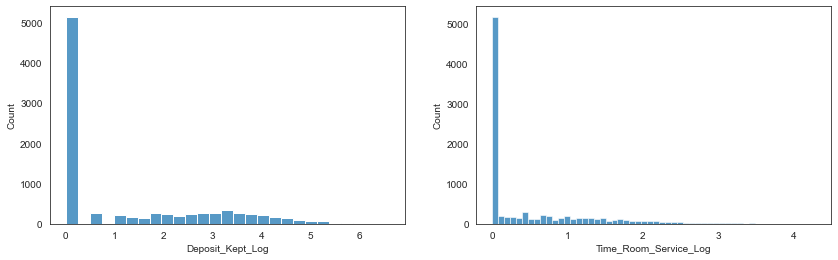

In [291]:
# histogramas das variáveis contínuas
fig, axes = plt.subplots(1,2, figsize = (14,4))
sns.histplot(ax = axes[0], data = data_trans, x = 'Deposit_Kept_Log')
sns.histplot(ax = axes[1], data = data_trans, x = 'Time_Room_Service_Log')
plt.show()

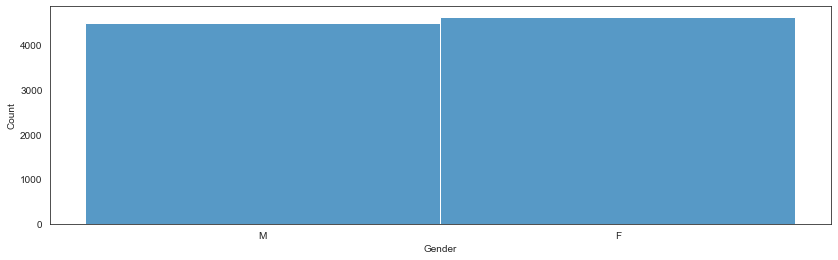

In [292]:
# histogramas de gênero
fig, axes = plt.subplots(figsize = (14,4))
sns.histplot(data = data_trans, x = 'Gender')
plt.show()

In [293]:
# metade do dataset possui valor 0 para o Deposit_Kept e Time_Room_Service
# serão criadas uma variável categórica para cada uma destas variáveis

data_trans['Deposit_Kept_Group'] = data_trans['Deposit_Kept']
data_trans['Deposit_Kept_Group'].loc[data_trans['Deposit_Kept_Group'] != 0] = 1

data_trans['Time_Room_Service_Group'] = data_trans['Time_Room_Service']
data_trans['Time_Room_Service_Group'].loc[data_trans['Time_Room_Service_Group'] != 0] = 1

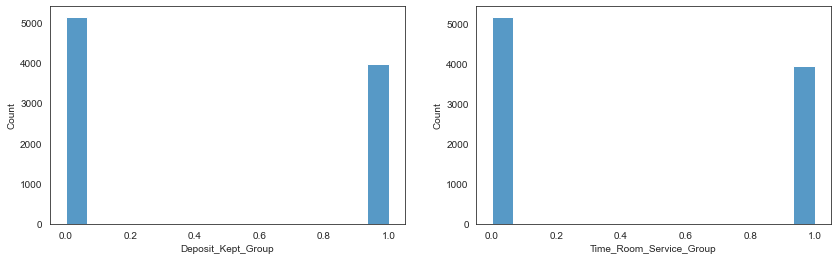

In [294]:
# histogramas das variáveis contínuas
fig, axes = plt.subplots(1,2, figsize = (14,4))
sns.histplot(ax = axes[0], data = data_trans, x = 'Deposit_Kept_Group')
sns.histplot(ax = axes[1], data = data_trans, x = 'Time_Room_Service_Group')
plt.show()

In [295]:
# Criando variáveis dummy para Frequent_Traveler, Type e Flight Class
data_trans = pd.get_dummies(data_trans, drop_first = True)

In [296]:
data_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9100 entries, 19346 to 22235
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Frequent_Traveler        9100 non-null   int64  
 1   Points                   9100 non-null   int64  
 2   Room                     9100 non-null   int64  
 3   Check-in/Check-out       9100 non-null   int64  
 4   F&B                      9100 non-null   int64  
 5   Location                 9100 non-null   int64  
 6   Wifi                     9100 non-null   int64  
 7   Entertainment            9100 non-null   int64  
 8   Gym                      9100 non-null   int64  
 9   Spa                      9100 non-null   int64  
 10  Staff                    9100 non-null   int64  
 11  Pool                     9100 non-null   int64  
 12  Baggage_Handling         9100 non-null   int64  
 13  Reception                9100 non-null   int64  
 14  Cleanliness        

In [297]:
data_final = data_trans[['Points', 'Age', 'Gender_M', 
                        'Frequent_Traveler', 'Type_Personal Travel', 'Flight_Class_Eco', 'Flight_Class_Eco Plus', 
                         'Deposit_Kept_Group', 'Time_Room_Service_Group',
                         'Room', 'Check-in/Check-out', 'F&B', 'Location', 'Wifi', 'Entertainment', 'Gym', 'Spa', 
                         'Staff', 'Pool', 'Baggage_Handling', 'Reception', 'Cleanliness', 'Online_Booking',
                         'Repeater'
                        ]].copy()



In [298]:
data_final.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9100 entries, 19346 to 22235
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Points                   9100 non-null   int64  
 1   Age                      8995 non-null   float64
 2   Gender_M                 9100 non-null   uint8  
 3   Frequent_Traveler        9100 non-null   int64  
 4   Type_Personal Travel     9100 non-null   uint8  
 5   Flight_Class_Eco         9100 non-null   uint8  
 6   Flight_Class_Eco Plus    9100 non-null   uint8  
 7   Deposit_Kept_Group       9100 non-null   int64  
 8   Time_Room_Service_Group  9100 non-null   float64
 9   Room                     9100 non-null   int64  
 10  Check-in/Check-out       9100 non-null   int64  
 11  F&B                      9100 non-null   int64  
 12  Location                 9100 non-null   int64  
 13  Wifi                     9100 non-null   int64  
 14  Entertainment      

## REDUÇÃO DE VARIÁVEIS
### Filther Methods


In [299]:
# variáveis iniciais:
list(data.columns)

['Name',
 'Frequent_Traveler',
 'Date_Birth',
 'Type',
 'Flight_Class',
 'Points',
 'Room',
 'Check-in/Check-out',
 'F&B',
 'Location',
 'Wifi',
 'Entertainment',
 'Gym',
 'Spa',
 'Staff',
 'Pool',
 'Baggage_Handling',
 'Reception',
 'Cleanliness',
 'Online_Booking',
 'Deposit_Kept',
 'Time_Room_Service',
 'Repeater']

In [300]:
# variáveis criadas
np.setdiff1d(list(data_final.columns), list(data.columns))

array(['Age', 'Deposit_Kept_Group', 'Flight_Class_Eco',
       'Flight_Class_Eco Plus', 'Gender_M', 'Time_Room_Service_Group',
       'Type_Personal Travel'], dtype='<U23')

<AxesSubplot:>

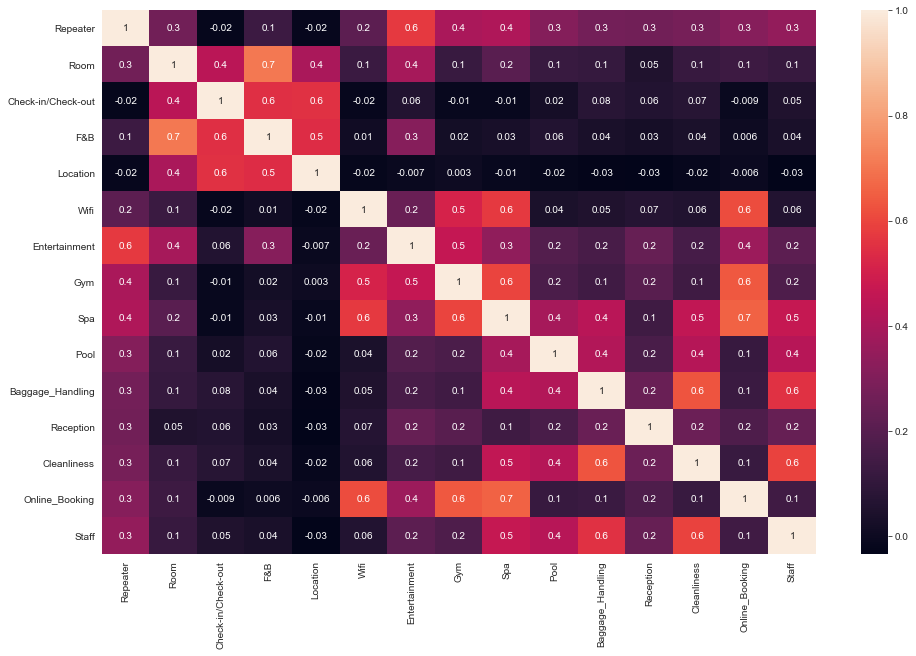

In [301]:
# correlação entre as variáveis de notas:
data_final_corr = data_final[['Repeater', 'Room', 'Check-in/Check-out', 'F&B', 'Location', 'Wifi', 'Entertainment',
                              'Gym', 'Spa', 'Pool', 'Baggage_Handling', 'Reception','Cleanliness',
                              'Online_Booking', 'Staff']].corr(method = 'spearman')
figure = plt.figure(figsize=(16,10))
sns.heatmap(data_final_corr, annot=True, fmt = '.1g')
# Obs: Room, Check-in/Check-out, F&B, e Location possuem correlação elevada entre si e pouca correlação com a DepVar

In [302]:
# Obs: Room, Check-in/Check-out, F&B, e Location possuem correlação elevada entre si e pouca correlação com a DepVar
data_final_fm = data_final.drop(['Room', 'Check-in/Check-out', 'F&B', 'Location'], axis = 1)

## Aplicando RFE nas variáveis que restaram

In [303]:
data_final['Frequent_Traveler'] = data_final['Frequent_Traveler'].astype('uint8')
data_final['Deposit_Kept_Group'] = data_final['Deposit_Kept_Group'].astype('uint8')
data_final['Time_Room_Service_Group'] = data_final['Time_Room_Service_Group'].astype('uint8')
data_final['Repeater'] = data_final['Repeater'].astype('uint8')

In [304]:
def select_best_features(data):
    X = data.drop('Repeater', axis = 1)
    y = data['Repeater'].copy()
    skf = StratifiedKFold(n_splits = 3)
    counter = 0
    for train_index, val_index in skf.split(X, y):
        counter +=1
        print('')
        print('--------------------------------------------------------')
        print('SPLIT ', counter)
        print('--------------------------------------------------------')
        print('')
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        
        # fill missing values (mean in numerical data, mode in categorical data)
        mean_age_train = X_train['Age'].mean()
        X_train['Age'].fillna(mean_age_train, inplace = True)
        
        # get all numerical variables
        X_train_num = X_train.select_dtypes(exclude='uint8').set_index(X_train.index)
        X_val_num = X_val.select_dtypes(exclude='uint8').set_index(X_val.index)
        
        # get all categorical variables
        X_train_cat = X_train.select_dtypes(include='uint8').set_index(X_train.index)
        X_val_num = X_val.select_dtypes(include='uint8').set_index(X_val.index)
        
        # Apply scaling to numerical data
        scaler = MinMaxScaler().fit(X_train_num)
        X_train_scaled = pd.DataFrame(scaler.transform(X_train_num), columns = X_train_num.columns) # MinMaxScaler in the training data
    
        
        # Check which features to use using RFE
        print('')
        print('----------------- RFE ----------------------')
        model = LogisticRegression()
        rfe = RFE(estimator = model, n_features_to_select = 8 )
        X_rfe = rfe.fit_transform(X = X_train_scaled, y = y_train)
        selected_features = pd.Series(rfe.support_, index = X_train_scaled.columns)
        print(selected_features)
        
        # Check which features to use using Chi-Square
        print('')
        print('----------------- CHI-SQUARE ----------------------')
        def TestIndependence(X,y,var,alpha=0.05):        
            dfObserved = pd.crosstab(y,X) 
            chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
            dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
            if p<alpha:
                result="{0} is IMPORTANT for Prediction".format(var)
            else:
                result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
            print(result)
        
        for var in X_train_cat:
            TestIndependence(X_train_cat[var],y_train, var)
            

In [305]:
data_final_fm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9100 entries, 19346 to 22235
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Points                   9100 non-null   int64  
 1   Age                      8995 non-null   float64
 2   Gender_M                 9100 non-null   uint8  
 3   Frequent_Traveler        9100 non-null   int64  
 4   Type_Personal Travel     9100 non-null   uint8  
 5   Flight_Class_Eco         9100 non-null   uint8  
 6   Flight_Class_Eco Plus    9100 non-null   uint8  
 7   Deposit_Kept_Group       9100 non-null   int64  
 8   Time_Room_Service_Group  9100 non-null   float64
 9   Wifi                     9100 non-null   int64  
 10  Entertainment            9100 non-null   int64  
 11  Gym                      9100 non-null   int64  
 12  Spa                      9100 non-null   int64  
 13  Staff                    9100 non-null   int64  
 14  Pool               

In [306]:
select_best_features(data_final_fm)


--------------------------------------------------------
SPLIT  1
--------------------------------------------------------


----------------- RFE ----------------------
Points                     False
Age                        False
Frequent_Traveler           True
Deposit_Kept_Group         False
Time_Room_Service_Group    False
Wifi                        True
Entertainment               True
Gym                         True
Spa                         True
Staff                       True
Pool                        True
Baggage_Handling           False
Reception                   True
Cleanliness                False
Online_Booking             False
dtype: bool

----------------- CHI-SQUARE ----------------------
Gender_M is IMPORTANT for Prediction
Type_Personal Travel is IMPORTANT for Prediction
Flight_Class_Eco is IMPORTANT for Prediction
Flight_Class_Eco Plus is IMPORTANT for Prediction

--------------------------------------------------------
SPLIT  2
---------------------

According to the previous results:
- Using RFE (selecting all the important features, as que aparecem pelo menos em um fold):
    - Entertainment
    - Spa
    - Time_Room_Service
    - Pool
    - Staff

- Using Chi-Square:
    - Type
    - Flight_Class

    
Concluding, we should keep the variables (this is a possible interpretation):
    - XXXX

In [307]:
data_final_rfe = data_final_fm.drop(['Points', 'Baggage_Handling', 'Cleanliness', 'Online_Booking'], axis = 1)

In [308]:
data_final_rfe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9100 entries, 19346 to 22235
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      8995 non-null   float64
 1   Gender_M                 9100 non-null   uint8  
 2   Frequent_Traveler        9100 non-null   int64  
 3   Type_Personal Travel     9100 non-null   uint8  
 4   Flight_Class_Eco         9100 non-null   uint8  
 5   Flight_Class_Eco Plus    9100 non-null   uint8  
 6   Deposit_Kept_Group       9100 non-null   int64  
 7   Time_Room_Service_Group  9100 non-null   float64
 8   Wifi                     9100 non-null   int64  
 9   Entertainment            9100 non-null   int64  
 10  Gym                      9100 non-null   int64  
 11  Spa                      9100 non-null   int64  
 12  Staff                    9100 non-null   int64  
 13  Pool                     9100 non-null   int64  
 14  Reception          

## Compare models using F1 Score

In [309]:
from sklearn.metrics import f1_score
import time

def compare_models(data, model):
    # apply StratifiedK-Fold
    skf = StratifiedKFold(n_splits = 5)
    score_train = []
    score_test = []
    X = data.drop('Repeater', axis = 1)
    y = data['Repeater'].copy()
    score_train = []
    score_val = []
    timer = []
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        
        # This time we are going to use validation to check overfitting 
        # so we need also to make all the needed changes in the validation
        
        # fill missing values (mean in numerical data, mode in categorical data)
        mean_age_train = X_train['Age'].mean()
        X_train['Age'].fillna(mean_age_train, inplace = True)
        X_val['Age'].fillna(mean_age_train, inplace = True) # fill with train values

        # Data Scaling
        # Apply MinMaxScaler
        scaler = MinMaxScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train) 
        X_val_scaled = scaler.transform(X_val) # Scaling with 'scaler' from train data

        # Apply model
        begin = time.perf_counter() # start counting time
        model.fit(X_train_scaled, y_train)
        end = time.perf_counter() # finish counting time
        predictions_train = model.predict(X_train_scaled)
        predictions_val = model.predict(X_val_scaled)
        score_train.append(f1_score(y_train, predictions_train))
        score_val.append(f1_score(y_val, predictions_val))
        timer.append(end-begin) # append time

        avg_train = round(np.mean(score_train),3)
        avg_val = round(np.mean(score_val),3)
        avg_time = round(np.mean(timer),3)
        std_train = round(np.std(score_train),2)
        std_val = round(np.std(score_val),2)
        std_time = round(np.std(timer),2)

    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train), str(avg_val) + '+/-' + str(std_val)
    
def show_results(df, data, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test = compare_models(data, arg)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test
        count+=1
    return df


# TESTANDO RANDON FOREST

In [258]:
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier()
model_DTC = DecisionTreeClassifier()
model_BDT = BaggingClassifier(DecisionTreeClassifier())

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['model_RF', 'model_DTC', 'model_BDT'])
show_results(df, data_final,             
             model_RF, model_DTC, model_BDT)

,Time,Train,Validation
model_RF,0.516+/-0.01,1.0+/-0.0,0.937+/-0.0
model_DTC,0.028+/-0.0,1.0+/-0.0,0.907+/-0.01
model_BDT,0.186+/-0.01,0.996+/-0.0,0.929+/-0.0


In [259]:
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier()
model_DTC = DecisionTreeClassifier()
model_BDT = BaggingClassifier(DecisionTreeClassifier())

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['model_RF', 'model_DTC', 'model_BDT'])
show_results(df, data_final_rfe,             
             model_RF, model_DTC, model_BDT)

,Time,Train,Validation
model_RF,0.414+/-0.02,1.0+/-0.0,0.907+/-0.0
model_DTC,0.015+/-0.0,1.0+/-0.0,0.867+/-0.01
model_BDT,0.103+/-0.0,0.992+/-0.0,0.895+/-0.01


# Hyperparametros de uma RF

In [260]:
# número de estimators

model_RF_1 = RandomForestClassifier(n_estimators = 500)
model_RF_2 = RandomForestClassifier(n_estimators = 600)
model_RF_3 = RandomForestClassifier(n_estimators = 700)

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['model_RF_1', 'model_RF_2', 'model_RF_3'])
show_results(df, data_final,             
             model_RF_1, model_RF_2, model_RF_3)

,Time,Train,Validation
model_RF_1,2.374+/-0.05,1.0+/-0.0,0.936+/-0.0
model_RF_2,2.98+/-0.11,1.0+/-0.0,0.935+/-0.0
model_RF_3,3.694+/-0.09,1.0+/-0.0,0.936+/-0.0


In [261]:
# número de estimators

model_RF_1 = RandomForestClassifier(min_samples_leaf = 1)
model_RF_2 = RandomForestClassifier(min_samples_leaf = 5)
model_RF_3 = RandomForestClassifier(min_samples_leaf = 10)

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['model_RF_1', 'model_RF_2', 'model_RF_3'])
show_results(df, data_final,             
             model_RF_1, model_RF_2, model_RF_3)

,Time,Train,Validation
model_RF_1,0.473+/-0.01,1.0+/-0.0,0.936+/-0.0
model_RF_2,0.435+/-0.01,0.96+/-0.0,0.925+/-0.0
model_RF_3,0.398+/-0.02,0.936+/-0.0,0.918+/-0.0


In [262]:
# número de estimators

model_RF_1 = RandomForestClassifier(min_samples_leaf = 1)
model_RF_2 = RandomForestClassifier(min_samples_leaf = 5)
model_RF_3 = RandomForestClassifier(min_samples_leaf = 10)

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['model_RF_1', 'model_RF_2', 'model_RF_3'])
show_results(df, data_final_rfe,             
             model_RF_1, model_RF_2, model_RF_3)

,Time,Train,Validation
model_RF_1,0.368+/-0.01,1.0+/-0.0,0.906+/-0.0
model_RF_2,0.313+/-0.0,0.927+/-0.0,0.894+/-0.0
model_RF_3,0.308+/-0.02,0.904+/-0.0,0.888+/-0.0


## Modelos MLP

In [263]:
model_NN_hl2 = MLPClassifier(hidden_layer_sizes = 2)
model_NN_hl10 = MLPClassifier(hidden_layer_sizes = 10)
model_NN_hl100 = MLPClassifier(hidden_layer_sizes = 100)

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['model_NN_hl2', 'model_NN_hl10', 'model_NN_hl100'])
show_results(df, data_final, 
             model_NN_hl2, model_NN_hl10, model_NN_hl100)

,Time,Train,Validation
model_NN_hl2,1.866+/-0.11,0.85+/-0.01,0.844+/-0.01
model_NN_hl10,3.293+/-0.07,0.915+/-0.0,0.909+/-0.0
model_NN_hl100,6.738+/-0.06,0.95+/-0.0,0.929+/-0.0


In [264]:
model_NN_hl2 = MLPClassifier(hidden_layer_sizes = 2)
model_NN_hl10 = MLPClassifier(hidden_layer_sizes = 10)
model_NN_hl100 = MLPClassifier(hidden_layer_sizes = 100)

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['model_NN_hl2', 'model_NN_hl10', 'model_NN_hl100'])
show_results(df, data_final_rfe, 
             model_NN_hl2, model_NN_hl10, model_NN_hl100)

,Time,Train,Validation
model_NN_hl2,1.623+/-0.65,0.82+/-0.06,0.817+/-0.06
model_NN_hl10,2.201+/-0.02,0.89+/-0.0,0.886+/-0.0
model_NN_hl100,6.548+/-0.18,0.911+/-0.0,0.899+/-0.0


In [265]:
model_NN_hl2 = MLPClassifier(hidden_layer_sizes = (2,2))
model_NN_hl10 = MLPClassifier(hidden_layer_sizes = (10,2))
model_NN_hl100 = MLPClassifier(hidden_layer_sizes = (100,2))

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['model_NN_hl2', 'model_NN_hl10', 'model_NN_hl100'])
show_results(df, data_final, 
             model_NN_hl2, model_NN_hl10, model_NN_hl100)

,Time,Train,Validation
model_NN_hl2,2.512+/-0.03,0.857+/-0.01,0.853+/-0.01
model_NN_hl10,4.017+/-0.12,0.91+/-0.01,0.906+/-0.01
model_NN_hl100,7.32+/-0.24,0.962+/-0.0,0.928+/-0.01


In [266]:
model_NN_hl2 = MLPClassifier(hidden_layer_sizes = (2,2))
model_NN_hl10 = MLPClassifier(hidden_layer_sizes = (10,2))
model_NN_hl100 = MLPClassifier(hidden_layer_sizes = (100,2))

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['model_NN_hl2', 'model_NN_hl10', 'model_NN_hl100'])
show_results(df, data_final_rfe, 
             model_NN_hl2, model_NN_hl10, model_NN_hl100)

,Time,Train,Validation
model_NN_hl2,2.339+/-0.33,0.842+/-0.01,0.841+/-0.01
model_NN_hl10,2.753+/-0.05,0.894+/-0.0,0.888+/-0.0
model_NN_hl100,7.093+/-0.32,0.92+/-0.0,0.901+/-0.01


In [267]:
model_NN_hl2 = MLPClassifier(hidden_layer_sizes = (2,3))
model_NN_hl10 = MLPClassifier(hidden_layer_sizes = (10,3))
model_NN_hl100 = MLPClassifier(hidden_layer_sizes = (100,3))

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['model_NN_hl2', 'model_NN_hl10', 'model_NN_hl100'])
show_results(df, data_final_rfe, 
             model_NN_hl2, model_NN_hl10, model_NN_hl100)

,Time,Train,Validation
model_NN_hl2,2.302+/-0.39,0.855+/-0.01,0.854+/-0.01
model_NN_hl10,2.834+/-0.15,0.895+/-0.0,0.89+/-0.0
model_NN_hl100,6.996+/-0.12,0.92+/-0.0,0.9+/-0.0


- __Conclusão__: No MLP, modelos com mais features precisam de mais neurônios nas camadas escondidas. 
O modelo full performa melhor com 100 neurônios, enquanto o modelo filtrado não tem ganhos com mais de 10 neurônios. Redes com 3 camadas escondidas performaram melhor até agora sem muito custo para o processamento.

- __Propostas de modelos_ `modelo fast`__: Bagging com modelo filtrado, 10 neuronios na camada escondida, 3 camadas escondidas
- __Propostas de modelos_ `modelo full`__: Bagging com modelo full, 100 neurônios na camada escondida, 3 camadas escondidas

# TESTANDO `MODELO FAST`

In [268]:
# com e sem bagging

model_bag_NN_10 = BaggingClassifier(MLPClassifier(hidden_layer_sizes = (10,3)))
model_NN_100 = MLPClassifier(hidden_layer_sizes = (10,3))

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['model_bag_NN', 'model_NN'])
show_results(df, data_final_rfe,             
             model_bag_NN, model_NN)

,Time,Train,Validation
model_bag_NN,64.05+/-2.61,0.922+/-0.0,0.901+/-0.0
model_NN,7.013+/-0.13,0.922+/-0.0,0.899+/-0.0


In [269]:
# com e sem bagging

model_bag_NN_10 = BaggingClassifier(MLPClassifier(hidden_layer_sizes = (10,2)))
model_NN_100 = MLPClassifier(hidden_layer_sizes = (10,2))

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['model_bag_NN', 'model_NN'])
show_results(df, data_final_rfe,             
             model_bag_NN, model_NN)

,Time,Train,Validation
model_bag_NN,66.803+/-3.0,0.922+/-0.0,0.902+/-0.0
model_NN,6.994+/-0.16,0.919+/-0.0,0.898+/-0.0


# TESTANDO `MODELO FULL`

In [270]:
# com e sem bagging
###### MELHOR MODELO ATÉ AGORA ###########

model_bag_NN_10 = BaggingClassifier(MLPClassifier(hidden_layer_sizes = (100,3)))
model_NN_100 = MLPClassifier(hidden_layer_sizes = (100,3))

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['model_bag_NN', 'model_NN'])
show_results(df, data_final,             
             model_bag_NN, model_NN)

,Time,Train,Validation
model_bag_NN,65.943+/-3.95,0.962+/-0.0,0.931+/-0.0
model_NN,9.337+/-1.54,0.961+/-0.01,0.931+/-0.0


In [271]:
# com e sem bagging

model_bag_NN_10 = BaggingClassifier(MLPClassifier(hidden_layer_sizes = (100,2)))
model_NN_100 = MLPClassifier(hidden_layer_sizes = (100,2))

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['model_bag_NN', 'model_NN'])
show_results(df, data_final,             
             model_bag_NN, model_NN)

,Time,Train,Validation
model_bag_NN,73.381+/-11.91,0.963+/-0.0,0.929+/-0.0
model_NN,7.203+/-0.35,0.964+/-0.0,0.929+/-0.0


# STACKING DE NN E RANDON FOREST

In [274]:
from sklearn.ensemble import StackingClassifier
estimators = [
    ('rfc', RandomForestClassifier(random_state = 42)),
    ('nn', MLPClassifier(hidden_layer_sizes = (100,3), random_state = 42))
]

model_RF = RandomForestClassifier(random_state = 42)
model_NN = MLPClassifier(hidden_layer_sizes = (100,3))
model_final = StackingClassifier(estimators=estimators)

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['RF', 'NN', 'model_final'])
show_results(df, data_final,             
             model_RF, model_NN, model_final)

,Time,Train,Validation
RF,0.47+/-0.01,1.0+/-0.0,0.934+/-0.0
NN,7.042+/-1.03,0.964+/-0.01,0.93+/-0.01
model_final,43.543+/-1.23,0.999+/-0.0,0.938+/-0.0


# AdaBoost

In [275]:
from sklearn.ensemble import AdaBoostClassifier
model_Ada = AdaBoostClassifier()
model_Ada2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200)

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['Ada','Ada2'])
show_results(df, data_final,             
             model_Ada, model_Ada2)

,Time,Train,Validation
Ada,0.28+/-0.04,0.901+/-0.0,0.898+/-0.01
Ada2,1.001+/-0.02,0.909+/-0.0,0.904+/-0.01


# GradientBoosting

In [277]:
from sklearn.ensemble import GradientBoostingClassifier
model_GB = AdaBoostClassifier(n_estimators=100)
model_GB2 = AdaBoostClassifier(n_estimators=200)
model_GB3 = AdaBoostClassifier(n_estimators=300)

df = pd.DataFrame(columns = ['Time', 'Train','Validation'], index = ['model_GB','model_GB2', 'model_GB3'])
show_results(df, data_final,             
             model_GB, model_GB2, model_GB3)

,Time,Train,Validation
model_GB,0.46+/-0.01,0.905+/-0.0,0.902+/-0.01
model_GB2,0.938+/-0.03,0.909+/-0.0,0.904+/-0.01
model_GB3,1.362+/-0.03,0.909+/-0.0,0.902+/-0.01


# Conclusão
- __`Número de Features`__: Após aplicar alguns métodos de redução de variáveis, chegou-se em um dataset com menos features. Entretanto, o tempo ganho na execução dos modelos não justificou a perda de precisão dos modelos, então o dataset completo foi utilizado
- __`Modelos utilizados`__: Para este trabalho, foram testados modelos de redes neurais e árvores de decisão em diferntes métodos de essemble. O modelo de rede neurão que melhor perfomou nesta análise foi um com 3 hidden layers e 100 neurônios em cada camada. Para as árvores de decisão, o melhor modelo foi uma randon forest com os parâmetros default. Ambos os modelos performaram de forma similar, entretanto os modelos de NN demoram sensivelmente mais tempo para serem executados, enquanto os modelos de árvores de decisão sofrem de overfitting

- __`Modelos utilizados`__: O modelo final neste trabalho foi um stacking de uma randon forest com uma rede neural. Outros modelos de essemble foram testados (AdaBoost e GradientBoosting) mas com performance inferior ao modelo selecionado.

# Aplicar modelo StackingClassifier, f1 = 0.9384)

## Create the final model and apply to the test dataset

According to the results, the best model is KNN with the default parameters since it performs better on validation and has a lower value of overfitting. __(Of course the f1_score in this case is really low and in your project you should apply some fine-tuning or apply different algorithms in order to get better results!)__ <br><br>
First, we are going to create our final model using all the training data (the more data the better and this model should have exactly the same structure than the selected model on the previous phase, i.e., a KNN with the default parameters.) <br><br>
Then we need to import the test dataset, made all the needed transformations and extract the csv with the answers.

#### Create final model

In [317]:
final_data = data[['Name', 'Date_Birth', 'Frequent_Traveler', 'Type', 'Flight_Class', 'Points', 'Room',
       'Check-in/Check-out', 'F&B', 'Location', 'Wifi', 'Entertainment', 'Gym',
       'Spa', 'Staff', 'Pool', 'Baggage_Handling', 'Reception', 'Cleanliness',
       'Online_Booking', 'Deposit_Kept', 'Time_Room_Service', 'Repeater']].copy()

X_final = final_data.iloc[:,:-1]
y_final = final_data.iloc[:,-1]

# criando a variável de gênero
X_final['Gender'] = X_final['Name'].str.slice(0,4)
X_final['Gender'].replace('Mr. ', 'M', inplace = True)
X_final['Gender'].replace('Mrs.', 'F', inplace = True)
X_final['Gender'].replace('Miss', 'F', inplace = True)
X_final.drop('Name', axis = 1, inplace = True)

# Criando variáveis: Age
X_final['Date_Birth'] = pd.to_datetime(X_final['Date_Birth'])
X_final['Age'] = 2021 - X_final['Date_Birth'].dt.year
X_final.drop('Date_Birth', axis = 1, inplace = True)

mode_Age = X_final['Age'].mean()
X_final['Age'].fillna(mode_Age, inplace = True)
        
# Create dummies a
# remove one of the variables (to avoid multicollinearity)
X_final_dummies = pd.get_dummies(X_final, drop_first = True)

# Agrupar os Deposit_Kept e Time_Room_Service
X_final_dummies['Deposit_Kept'].loc[X_final_dummies['Deposit_Kept'] != 0] = 1
X_final_dummies['Time_Room_Service'].loc[X_final_dummies['Time_Room_Service'] != 0] = 1


# Data Scaling
# Apply MinMaxScaler
scaler = MinMaxScaler().fit(X_final_dummies)
X_final_scaled = scaler.transform(X_final_dummies) 

# Create your final model with exactly the same parameters than your best model during model comparison
final_model = StackingClassifier(estimators=estimators).fit(X_final_scaled, y_final)

### Aplicar no dataset de teste

In [320]:
test = pd.read_csv(r'./datasets/test.csv')
test.set_index('Guest_ID', inplace = True)


test_final = test[['Name', 'Date_Birth', 'Frequent_Traveler', 'Type', 'Flight_Class', 'Points', 'Room',
       'Check-in/Check-out', 'F&B', 'Location', 'Wifi', 'Entertainment', 'Gym',
       'Spa', 'Staff', 'Pool', 'Baggage_Handling', 'Reception', 'Cleanliness',
       'Online_Booking', 'Deposit_Kept', 'Time_Room_Service']].copy()

# criando a variável de gênero
test_final['Gender'] = test_final['Name'].str.slice(0,4)
test_final['Gender'].replace('Mr. ', 'M', inplace = True)
test_final['Gender'].replace('Mrs.', 'F', inplace = True)
test_final['Gender'].replace('Miss', 'F', inplace = True)
test_final.drop('Name', axis = 1, inplace = True)

# Criando variáveis: Age
test_final['Date_Birth'] = pd.to_datetime(test['Date_Birth'])
test_final['Age'] = 2021 - test_final['Date_Birth'].dt.year
test_final.drop('Date_Birth', axis = 1, inplace = True)

mode_Age = test_final['Age'].mean()
test_final['Age'].fillna(mode_Age, inplace = True)

        
# Create dummies a
# remove one of the variables (to avoid multicollinearity)
test_final_dummies = pd.get_dummies(test_final, drop_first = True)

# If we don't have all the values in the test dataset that we have in the train, that column will not be created
# We should assure that all columns in train are also present in test
# Get missing columns from the training dataset
missing_cols = set(X_final_dummies.columns ) - set(test_final_dummies.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_final_dummies[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test_final_dummies = test_final_dummies[X_final_dummies.columns]

# Data Scaling
# Apply MinMaxScaler
scaler = MinMaxScaler().fit(test_final_dummies)
test_final_scaled = scaler.transform(test_final_dummies)

### Exportar o CSV

In [321]:
test_final['Repeater'] = final_model.predict(test_final_scaled)
final_csv = test_final['Repeater'].copy()
final_csv.to_csv(r'./datasets/result.csv')

In [326]:
final_csv

Guest_ID
19847    0
12433    1
10273    1
12457    0
22903    0
        ..
18266    1
21243    1
19539    0
15253    0
22708    1
Name: Repeater, Length: 3900, dtype: int64